### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

### Переходим к практике

![ab_split](tm1.png "TM1")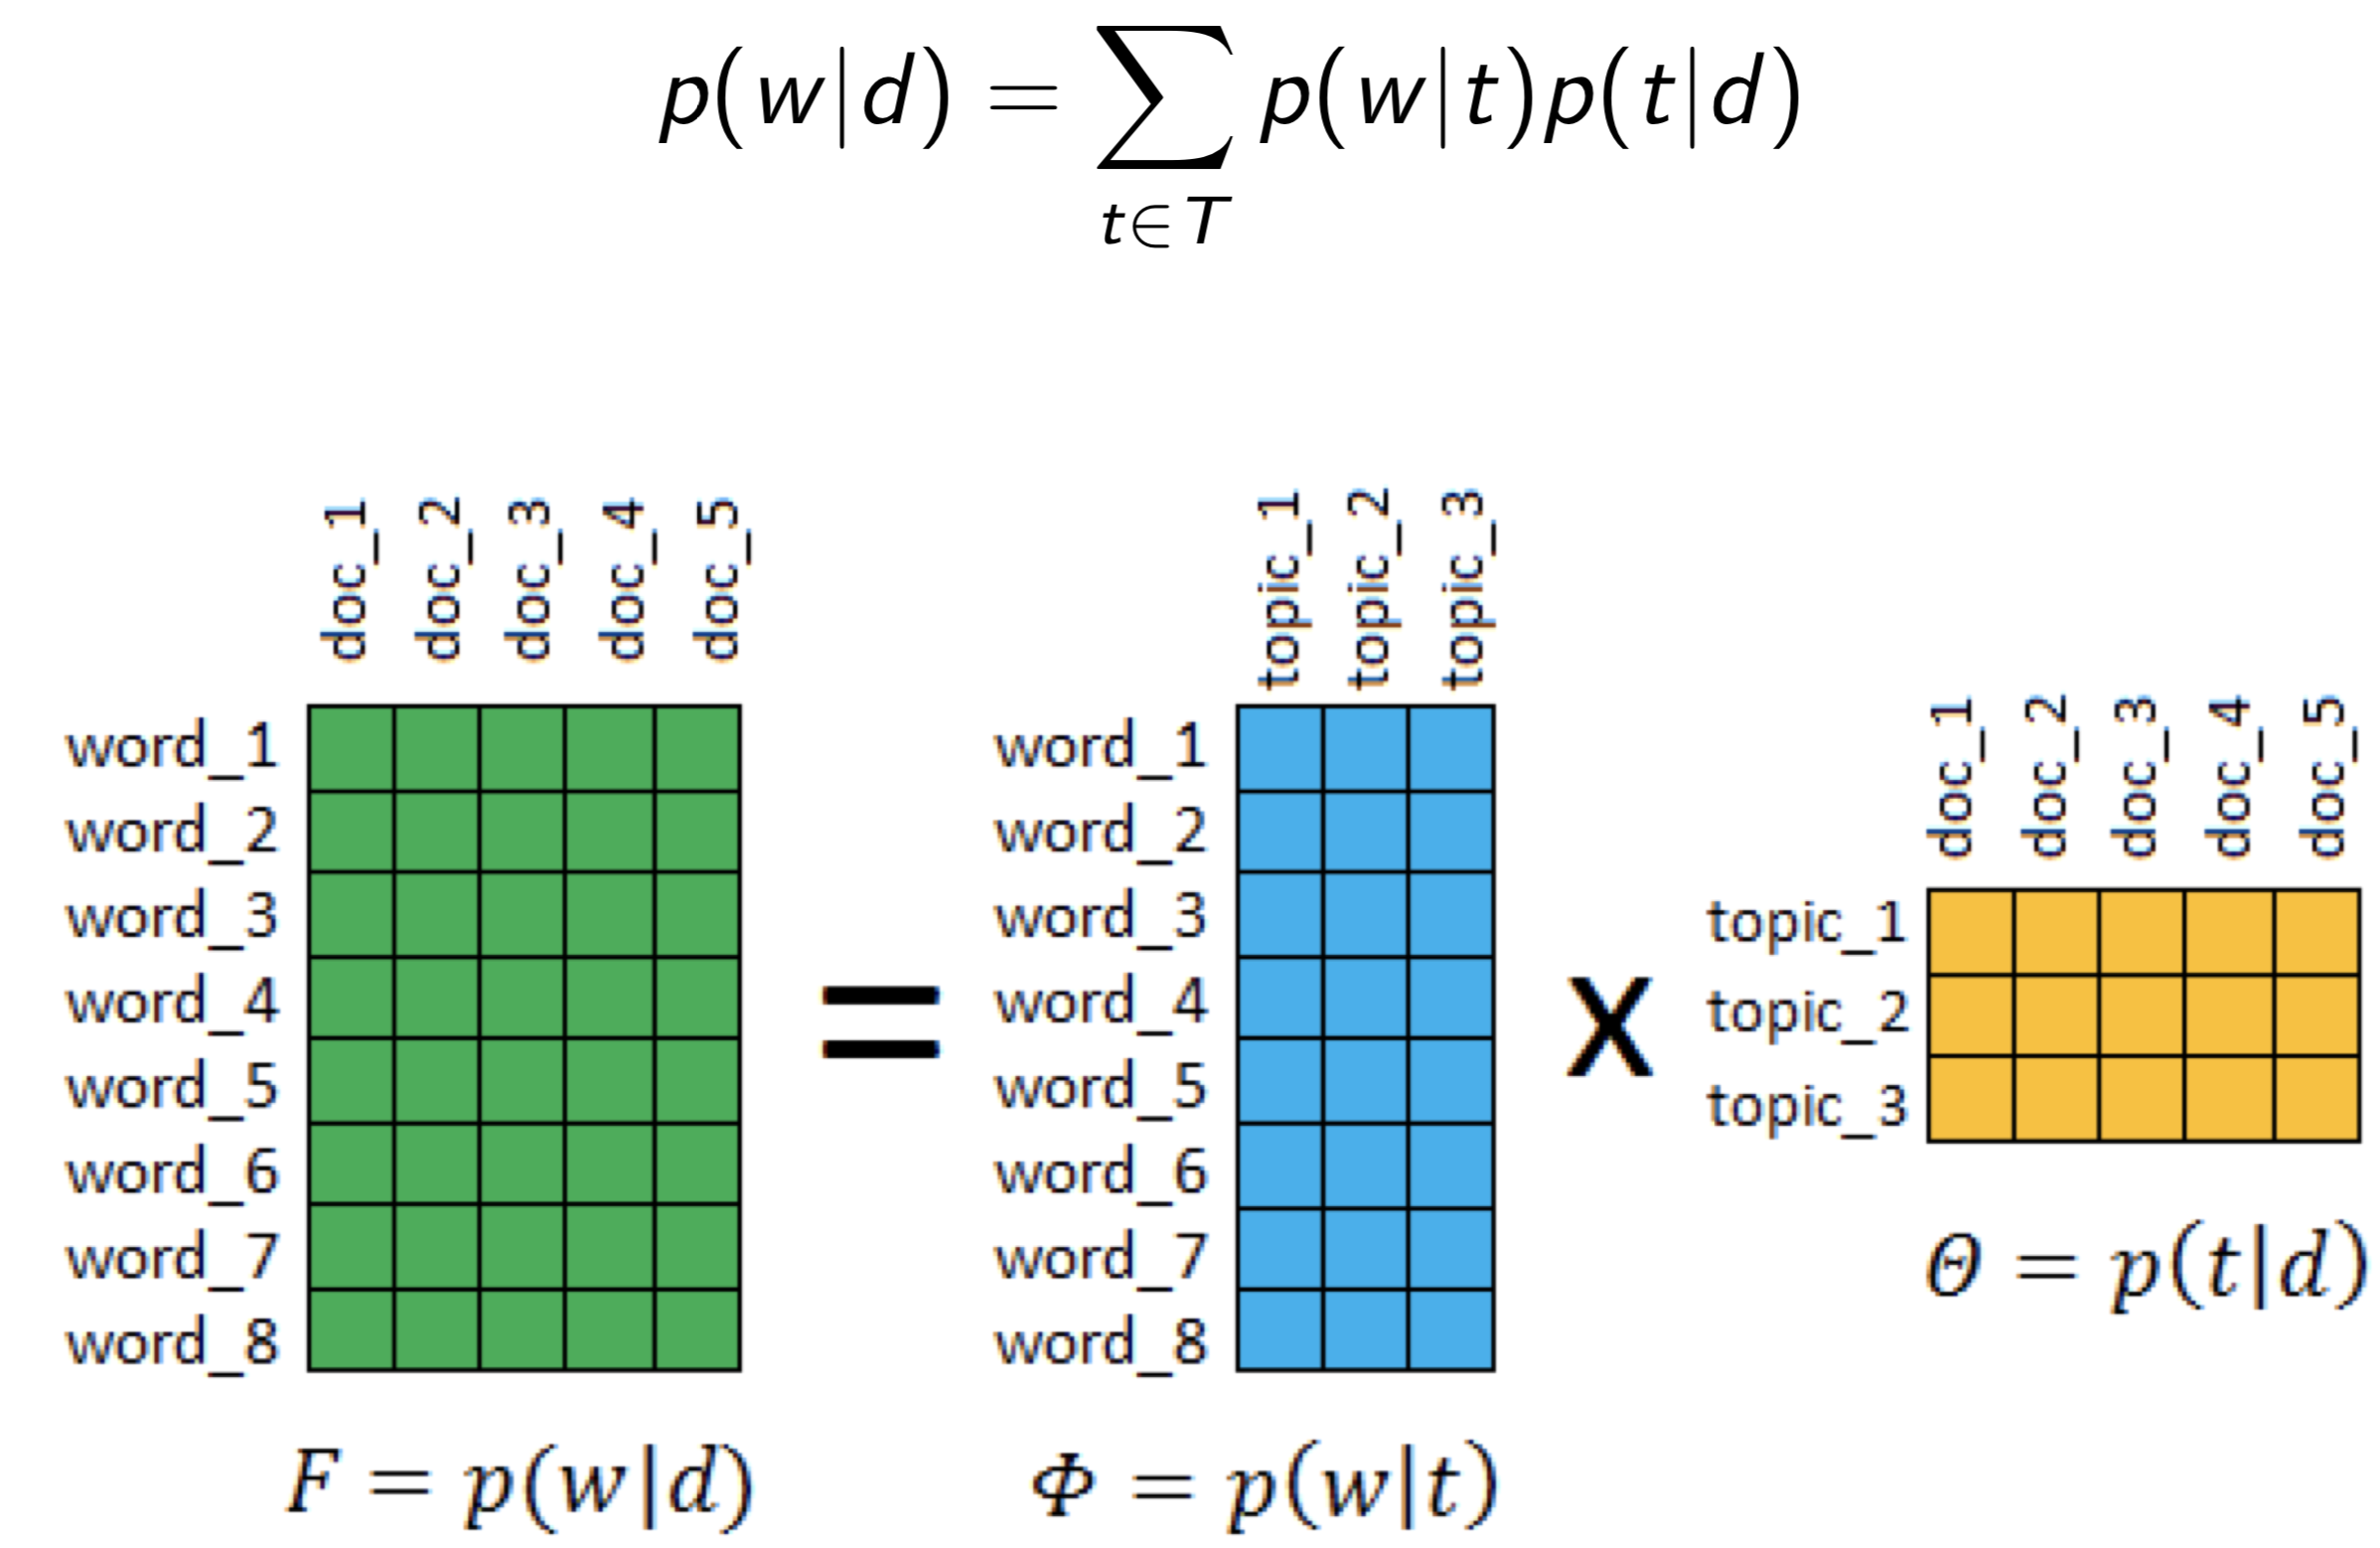

In [ ]:
import pandas as pd
import numpy as np


# Для дополнительных преобразований числовых и текстовых признаков
from sklearn.base import BaseEstimator, TransformerMixin


# Непосредственно пайплайн для подготовки датафрейма
from sklearn.pipeline import Pipeline

# TfidVectorizer конвертирует датасет в матрицу Меры оценки важности слова в контексте документа (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.corpora.dictionary import Dictionary
#предобработка текстов
import re
from nltk.corpus import stopwords
from razdel import tokenize # https://github.com/natasha/razdel
import pymorphy2  # pip install pymorphy2


from gensim.models import LdaModel

In [ ]:
pip install pymorphy2

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Создание словаря стоп слов

In [ ]:
stopword_ru = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

Наши новости и пользователи со списком id последних 6 прочитанных новостей

In [ ]:
news = pd.read_csv("materials.csv")
users = pd.read_csv("users_articles.csv")
tuple_nu = news, users
for el in tuple_nu:
  print(el)

       doc_id                                              title
0           6  Заместитель председателяnправительства РФnСерг...
1        4896  Матч 1/16 финала Кубка России по футболу был п...
2        4897  Форвард «Авангарда» Томаш Заборский прокоммент...
3        4898  Главный тренер «Кубани» Юрий Красножан прокомм...
4        4899  Решением попечительского совета владивостокско...
...       ...                                                ...
26995  513441  Ученые Токийского университета морских наук и ...
26996  513442  Главой кафедры отечественной истории XX века и...
26997  513443  Американские ученые уточнили возраст расположе...
26998  513444  За последние 50 лет тропический углеродный цик...
26999  513445  У живших примерно 7 тыс. лет назад на территор...

[27000 rows x 2 columns]
          uid                                        articles
0     u105138  [293672, 293328, 293001, 293622, 293126, 1852]
1     u108690          [3405, 1739, 2972, 1158, 1599, 322665]
2     u1

### 1. Получаем векторные представления новостей

#### Функциональная очистка и лематизация

In [ ]:
def clean_text(text):
    '''
    очистка текста
    на выходе очищеный текст

    '''
    if not isinstance(text, str):
        text = str(text)

    text = text.lower() # преобразование всего текста к нпижнему регистру
    text = text.strip('\n').strip('\r').strip('\t') # удаляем из "строки/документа" перенос
    #строки табуляцию и перенос каретки с начала и с конца строки
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text)) # замена строки подстрокой (удаление символов)

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip()) #замена всех возможных пробелов на 1 пробед
    text = re.sub('n', ' ', text)

    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]

    #return " ".join(words)
    return text


cache = {}
def lemmatization(text):
    '''
    лемматизация -
        процесс приведения словоформы к лемме — её нормальной (словарной) форме.
        для существительных — именительный падеж, единственное число;
        для прилагательных — именительный падеж, единственное число, мужской род;
        для глаголов, причастий, деепричастий — глагол в инфинитиве (неопределённой форме) несовершенного вида.
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''


    # [0]
    if not isinstance(text, str): # проверка на принадлежность к класу str строки
        text = str(text)

    # [1]
    tokens = list(tokenize(text)) #импортировали из  razdel import tokenize
    words = [_.text for _ in tokens]


    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]

    return words_lem_without_stopwords

In [ ]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)
news

<ipython-input-17-f061f320cb4a>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 5min 4s, sys: 846 ms, total: 5min 4s
Wall time: 5min 19s


,doc_id,title
0,6,"[заместитель, председатель, правительство, рф,..."
1,4896,"[матч, финал, кубок, россия, футбол, приостано..."
2,4897,"[форвард, авангард, томаш, заборский, прокомме..."
3,4898,"[главный, тренер, кубань, юрий, красножанин, п..."
4,4899,"[решение, попечительский, совет, владивостокск..."
...,...,...
26995,513441,"[учёный, токийский, университет, морской, наук..."
26996,513442,"[глава, кафедра, отечественный, история, xx, в..."
26997,513443,"[американский, учёный, уточнить, возраст, расп..."
26998,513444,"[последний, тропический, углеродный, цикл, чув..."


#### ОПП очистка и лематизация входных данных


In [ ]:
class Clearing(BaseEstimator, TransformerMixin):
  def __init__(self, key):
    self.key = key

  def clean_text(self, text, key):
    '''
    очистка текста на выходе очищеный текст (строка фрейма)
    '''
    if not isinstance(self.text, str):
      self.text = str(text)

    self.text = text[key].lower() # преобразование всего текста к нпижнему регистру
    self.text = text[key].strip('\n').strip('\r').strip('\t') # удаляем из "строки/документа" перенос
    self.text = re.sub('n', ' ', text[key])
    #строки табуляцию и перенос каретки с начала и с конца строки
    self.text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text[key])) # замена строки подстрокой (удаление символов)
    self.text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text[key])
    self.text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text[key])
    self.text = re.sub(r'[\xad]|[\s+]', ' ', text[key].strip()) #замена всех возможных пробелов на 1 пробед
    return text



  def fit(self, X, y = None):
    return self

  def transform(self, X):
    """используем функцию  clean_text и применяем ее построчно к фрейму"""
    X[self.key] = X[self.key].apply(lambda x: clean_text(x), 1)
    return X[self.key]

class Lemmatization(BaseEstimator, TransformerMixin):
  def __init__(self, key):
    self.key = key

  def lemmatization(self, text, key):
    '''
    лемматизация -
        процесс приведения словоформы к лемме — её нормальной (словарной) форме.
        для существительных — именительный падеж, единственное число;
        для прилагательных — именительный падеж, единственное число, мужской род;
        для глаголов, причастий, деепричастий — глагол в инфинитиве (неопределённой форме) несовершенного вида.
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''
    cache = {}

    # [0]
    if not isinstance(text, str): # проверка на принадлежность к класу str строки
        self.text = str(text)

    # [1]
    tokens = list(tokenize(self.text)) #импортировали из  razdel import tokenize
    words = [_.text for _ in tokens]


    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]

    return words_lem_without_stopwords


  def fit(self, X, y = None):
    return self

  def transform(self, X):
    """используем функцию lemmatization и применяем ее построчно к фрейму"""
    X[self.key] = X[self.key].apply(lambda x: lemmatization(x), 1)
    return X[self.key]

In [ ]:


#pipeline_news = Pipeline([
  #  ('clearing', Clearing(key='title')),
  #  ('lemmatization', Lemmatization(key='title'))
  #  'lda', LdaModel([common_dictionary.doc2bow(text) for text in texts],
  #                                           num_topics=14,
  #                                          id2word=Dictionary([t for t in X.keys.values])
  #                                          )]

0        заместитель председателяnправительства рфnсерг...
1        матч  финала кубка россии по футболу был приос...
2        форвард авангарда томаш заборский прокомментир...
3        главный тренер кубани юрий красножан прокоммен...
4        решением попечительского совета владивостокско...
                               ...                        
26995    ученые токийского университета морских наук и ...
26996    главой кафедры отечественной истории xx века и...
26997    американские ученые уточнили возраст расположе...
26998    за последние  лет тропический углеродный цикл ...
26999    у живших примерно  тыс лет назад на территории...
Name: title, Length: 27000, dtype: object

In [ ]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

#### common_dictionary
это генератор словарь в котором всем словам взятых из документов присвоен индекс (ключь). Слова берутся без повторов  
#### common_corpus
это список состоящий из списокв документов в котором частота каждого слова в документе представлена в виде кортежа при этом если слова нет в документе то и кортежа на это слово нет.

In [ ]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

 ### Обучение (выделение тем(тегов) из статей)

In [ ]:
from gensim.models import LdaModel
N_topic = 14
# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=2)  # можно было менять

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [ ]:
x=lda.show_topics(num_topics=N_topic, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words
for topic,words in topics_words:
    print("topic_{}: ".format(topic+1)+" ".join(words))

topic_1: сша американский газ военный трамп погибнуть северный
topic_2: россия российский нефть сша экономика снижение война
topic_3: руб объект статья москва здание территория дом
topic_4: самолёт космический корабль полёт земля аппарат вода
topic_5: площадь школа квартира театр артист девочка золото
topic_6: млрд ракета бюджет расход доход конкурс бюджетный
topic_7: ребёнок банк выяснить станция семья родитель обращение
topic_8: млн тыс цена составить около данные изз
topic_9: учёный всё исследование исследователь жизнь женщина очень
topic_10: журнал турист первый участник статья день русский
topic_11: украина украинский фонд газпром киев церковь порошенко
topic_12: россия новый рубль эксперт российский всё решение
topic_13: поверхность городской район констатировать иск индия челябинский
topic_14: гражданин сотрудник ведомство эксперимент уголовный управление источник


Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [ ]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [ ]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(6)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
0,6,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.657844,0.000000,0.000000,0.102695,0.0,0.232005,0.0,0.000000
1,4896,0.0,0.000000,0.000000,0.539484,0.0,0.0,0.000000,0.000000,0.232016,0.113242,0.0,0.000000,0.0,0.096440
2,4897,0.0,0.053979,0.000000,0.000000,0.0,0.0,0.000000,0.127719,0.574381,0.000000,0.0,0.000000,0.0,0.224700
3,4898,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.650525,0.048092,0.0,0.291280,0.0,0.000000
4,4899,0.0,0.000000,0.077109,0.000000,0.0,0.0,0.000000,0.000000,0.148273,0.000000,0.0,0.751412,0.0,0.000000
5,4900,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.048421,0.730027,0.000000,0.0,0.143854,0.0,0.065065


### Следующий шаг - векторные представления пользователей

In [ ]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))
# ['topic_{}'.format(i) for i in range(25)] - ссылается на все столбцы с темами

doc_dict это словарь в котором каждый id статьи связан с  темами получеными в ходе обучения LDA

### Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

### Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее, а максимум. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

#### (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=True)
tfidf_user_art = vectorizer.fit_transform(users['articles'])
idf_vect_df = pd.DataFrame(zip(vectorizer.get_feature_names_out(), vectorizer.idf_), columns=['id_articl', 'idf'])
idf_vect_df.to_csv('idf_vect_csv', index=False)

def get_user_embedding_final_with_tfidf(users=users, user_column = 'user_column', doc_dict=doc_dict, N_topic=N_topic, idf_vect_df = None, strategy = 'np.max'):
  """
  функция выполняет эмбединг(вектризует пользователя по темам) пользователя
  по ранее полученым темама в ходе LDA обучения на текстах из статей """
  #users- df со списком польователей
  #doc_dict - словарь в котором каждый id статьи связан с  темами получеными в ходе обучения LDA
  #N_topic- количество тем выделеных в ходе LDA
  #idf_vect_df - df c в котором id статьи связан с его idf
  #user_column - колонка со списком статей
  #strategy - способ создания эмбединга для пользователей

  #надо еще задать через параметры doc_id и id_articl

  user_embeddings = pd.DataFrame(columns = ['topic_{}'.format(i) for i in range(N_topic)])
  for el in users[user_column]:
      user_articles_list = eval(el)
      user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
      if strategy == 'np.max':
        user_vector = np.max(user_vector, 0)
      elif strategy == 'np.median':
        user_vector = np.median(user_vector, 0)
      elif strategy == 'np.mean':
        user_vector = np.mean(user_vector, 0)
      elif strategy == 'tfidf':
        user_vector = np.zeros((len(user_articles_list), N_topic))
        for i, doc_id in enumerate(user_articles_list):
          try:
              weight = idf_vect_df[idf_vect_df['id_articl'] == str(doc_id)]['idf'].values[0]
          except Exception as e:
              weight = 0
          user_vector[i] = doc_dict[doc_id] * weight

        user_vector = np.median(user_vector, axis=0)

      user_embeddings.loc[len(user_embeddings.index)] = user_vector
  user_embeddings['uid'] = users['uid'].values
  user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
  return user_embeddings

#### Эмбендинг по стратегии idf

In [ ]:
user_embeddings_tfidf = get_user_embedding_final_with_tfidf(users=users, user_column = 'articles',
                                                            doc_dict=doc_dict, N_topic=N_topic,
                                                            idf_vect_df = idf_vect_df, strategy = 'tfidf')
user_embeddings_tfidf

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
0,u105138,0.781960,0.000000,0.593633,0.000000,0.0,0.0,1.014537,0.239444,0.419622,2.220177,0.000000,1.172295,0.000000,0.634578
1,u108690,0.427646,0.390840,0.165732,0.184773,0.0,0.0,0.254725,0.423404,1.171785,0.000000,0.323391,2.138760,0.000000,0.819216
2,u108339,0.729085,0.115386,1.183989,0.397904,0.0,0.0,0.516829,0.401427,0.000000,0.338002,0.043150,1.647448,0.000000,1.562734
3,u101138,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,3.473212,1.163249,0.089761,0.289004,0.000000,0.185627
4,u108248,0.116298,0.335989,0.067210,0.406548,0.0,0.0,0.317855,0.617420,1.424310,0.162966,0.000000,1.670696,0.000000,0.610104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,u107463,0.578493,0.000000,0.502864,0.000000,0.0,0.0,0.467814,0.000000,0.000000,0.131634,0.000000,1.667628,0.000000,2.792766
7996,u101241,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2.689797,1.157756,0.000000,0.000000,0.000000,0.000000
7997,u106486,0.309659,0.000000,0.424498,0.000000,0.0,0.0,0.000000,0.105137,0.000000,0.418099,0.067093,1.456735,0.000000,2.439749
7998,u102220,0.136545,0.000000,0.000000,0.464411,0.0,0.0,0.000000,0.237223,0.621941,0.318908,0.000000,0.000000,0.000000,0.000000


#### Эмбендинг по стратегии MAX

In [ ]:
user_embeddings_max = get_user_embedding_final_with_tfidf(users=users, user_column = 'articles',
                                                            doc_dict=doc_dict, N_topic=N_topic, strategy = 'np.max')
user_embeddings_max

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
0,u105138,0.271501,0.184912,0.157438,0.183225,0.102722,0.057068,0.129649,0.164181,0.118616,0.409252,0.333893,0.365708,0.000000,0.228251
1,u108690,0.290796,0.398066,0.106795,0.107462,0.036995,0.045995,0.136528,0.098486,0.228031,0.131063,0.190581,0.459648,0.033138,0.439642
2,u108339,0.459473,0.049613,0.376453,0.124621,0.070509,0.027443,0.082485,0.104851,0.120003,0.126747,0.060763,0.362895,0.018008,0.319563
3,u101138,0.335654,0.098814,0.072563,0.297017,0.682649,0.015091,0.019755,0.000000,0.527905,0.470133,0.151716,0.132473,0.000000,0.321878
4,u108248,0.058488,0.171585,0.383538,0.063136,0.062840,0.000000,0.126523,0.550463,0.295661,0.197283,0.235334,0.487269,0.015226,0.208289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,u107463,0.191678,0.263209,0.112896,0.278580,0.070852,0.030238,0.099039,0.059411,0.207550,0.070556,0.064507,0.768539,0.000000,0.501160
7996,u101241,0.000000,0.210215,0.033592,0.066100,0.000000,0.000000,0.214313,0.781218,0.604750,0.390825,0.013131,0.743115,0.000000,0.078659
7997,u106486,0.444380,0.229373,0.450233,0.097459,0.070909,0.000000,0.146033,0.115307,0.238797,0.127331,0.042979,0.300373,0.000000,0.486676
7998,u102220,0.416697,0.000000,0.094992,0.334794,0.432030,0.144632,0.036791,0.970002,0.747715,0.341042,0.000000,0.177328,0.030697,0.000000


#### Эмбендинг по стратегии Median

In [ ]:
user_embeddings_median = get_user_embedding_final_with_tfidf(users=users, user_column = 'articles',
                                                            doc_dict=doc_dict, N_topic=N_topic, strategy = 'np.median')
user_embeddings_median

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
0,u105138,0.085769,0.000000,0.070857,0.000000,0.0,0.0,0.113575,0.029216,0.050087,0.247604,0.000000,0.128465,0.000000,0.073883
1,u108690,0.049312,0.047330,0.019818,0.021307,0.0,0.0,0.029256,0.046061,0.140256,0.000000,0.036714,0.240615,0.000000,0.097606
2,u108339,0.086278,0.012415,0.139439,0.046554,0.0,0.0,0.061592,0.047160,0.000000,0.040891,0.005265,0.194563,0.000000,0.176005
3,u101138,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.413345,0.141936,0.010952,0.034496,0.000000,0.022157
4,u108248,0.013521,0.040104,0.007814,0.049496,0.0,0.0,0.038422,0.073461,0.174050,0.018947,0.000000,0.203711,0.000000,0.074929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,u107463,0.072786,0.000000,0.063781,0.000000,0.0,0.0,0.062040,0.000000,0.000000,0.017344,0.000000,0.201869,0.000000,0.347046
7996,u101241,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.323504,0.142849,0.000000,0.000000,0.000000,0.000000
7997,u106486,0.037860,0.000000,0.054328,0.000000,0.0,0.0,0.000000,0.012549,0.000000,0.054489,0.008343,0.191997,0.000000,0.302526
7998,u102220,0.016661,0.000000,0.000000,0.055433,0.0,0.0,0.000000,0.028945,0.079837,0.034313,0.000000,0.000000,0.000000,0.000000


#### Эмбендинг по стратегии MEAN

In [ ]:
user_embeddings_mean = get_user_embedding_final_with_tfidf(users=users, user_column = 'articles',
                                                            doc_dict=doc_dict, N_topic=N_topic, strategy = 'np.mean')
user_embeddings_mean

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13
0,u105138,0.105847,0.043927,0.075819,0.030538,0.024508,0.009511,0.080371,0.050870,0.053228,0.224521,0.058751,0.140633,0.000000,0.083778
1,u108690,0.083488,0.128465,0.041492,0.028829,0.006166,0.007666,0.038719,0.050632,0.129941,0.023741,0.071621,0.240651,0.005523,0.136794
2,u108339,0.171338,0.017070,0.166801,0.056765,0.015437,0.004574,0.052528,0.045968,0.025609,0.056259,0.016842,0.169853,0.005190,0.191525
3,u101138,0.073587,0.020782,0.012094,0.064271,0.126218,0.002515,0.003293,0.000000,0.320944,0.204000,0.038829,0.048216,0.000000,0.073205
4,u108248,0.021645,0.062284,0.080381,0.038737,0.012299,0.000000,0.050399,0.141082,0.171961,0.047015,0.046152,0.222292,0.002538,0.091360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,u107463,0.087773,0.046381,0.054668,0.062053,0.011809,0.007261,0.055604,0.017199,0.034592,0.029054,0.010751,0.285158,0.000000,0.287486
7996,u101241,0.000000,0.059128,0.005599,0.017818,0.000000,0.000000,0.035719,0.194559,0.343261,0.173237,0.002189,0.130919,0.000000,0.013110
7997,u106486,0.149577,0.048571,0.118209,0.021044,0.011818,0.000000,0.031097,0.028288,0.057633,0.051806,0.016418,0.183988,0.000000,0.271787
7998,u102220,0.084224,0.000000,0.018237,0.103281,0.081414,0.029365,0.010628,0.330293,0.197520,0.092016,0.000000,0.029555,0.005116,0.000000


### Обучение

In [ ]:
target = pd.read_csv("users_churn.csv")
X_median = pd.merge(user_embeddings_median, target, 'left')
X_max = pd.merge(user_embeddings_max, target, 'left')
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_tfidf = pd.merge(user_embeddings_tfidf, target, 'left')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, precision_score, precision_recall_curve, average_precision_score

%matplotlib inline

In [ ]:
def metrics(y_test, preds):
    metric_dict = {}
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    metric_dict['Best Threshold'] = thresholds[ix]
    metric_dict['F-Score'] = fscore[ix]
    metric_dict['precision'] = precision[ix]
    metric_dict['recall'] = recall[ix]
    metric_dict['roc_auc_score'] = roc_auc_score(y_test, preds)
    metric_dict['pr_score'] = average_precision_score(y_test, preds)
    return metric_dict

In [ ]:
logreg = LogisticRegression()

MEDIAN

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(N_topic)]],
                                                    X_median['churn'], random_state=0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
median = metrics(y_test, preds)


MAX

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(N_topic)]],
                                                    X_max['churn'], random_state=0)

#обучим наш пайплайн
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
max = metrics(y_test, preds)

MEAN

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X_mean[['topic_{}'.format(i) for i in range(N_topic)]],
                                                    X_mean['churn'], random_state=0)

#обучим наш пайплайн
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
mean = metrics(y_test, preds)

TFIDF

In [ ]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf[['topic_{}'.format(i) for i in range(N_topic)]],
                                                    X_tfidf['churn'], random_state=0)

#обучим наш пайплайн
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]
tfidf = metrics(y_test, preds)

In [ ]:
metrics_df = pd.DataFrame(median.values(), index=median.keys(), columns=['median_strategy'])
metrics_df.insert(loc=len(metrics_df.columns), column='mean_strategy', value=mean.values())
metrics_df.insert(loc=len(metrics_df.columns), column='max_strategy', value=max.values())
metrics_df.insert(loc=len(metrics_df.columns), column='tfidf_strategy', value=tfidf.values())
metrics_df

,median_strategy,mean_strategy,max_strategy,tfidf_strategy
Best Threshold,0.242512,0.295648,0.273063,0.420082
F-Score,0.648936,0.645030,0.665517,0.752643
precision,0.573668,0.641129,0.576119,0.780702
recall,0.746939,0.648980,0.787755,0.726531
roc_auc_score,0.936006,0.931487,0.938555,0.967786
pr_score,0.679510,0.664170,0.716605,0.834738


Лучшеи метрики показала idf стратегия. idf в отличии от остальных метрик учитывает вес статьи в информационном поле пользователей так например есть статьи которые будут читать почти все пользователи а есть статьи которые читают единицы idf уменьшит влияние статей которые читаю все и будет акцинтироваться на более редких событиях.

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation